In [1550]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from skew_autotransform import skew_autotransform
from category_encoders import OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance, plot_partial_dependence
from imblearn.over_sampling import SMOTE

In [1551]:
#Read in data path
data = 'C:/Users/rebel/Downloads/phl_exoplanet_catalog.csv'

In [1552]:
#Create wrangle function
def wrangle(data):
    
    df = pd.read_csv(data)

    #Drop constant columns
    df.drop(columns=['P_STATUS', 'P_TEMP_MEASURED', 'P_GEO_ALBEDO_ERROR_MIN', 
                     'P_GEO_ALBEDO_ERROR_MAX'], inplace=True)

    #Drop High Cardinality Categorical Variables
    df.drop(columns=['S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG', 'P_NAME', 
                     'P_UPDATED', 'S_NAME', 'S_TYPE', 'S_ALT_NAMES', 'S_RA_T', 'S_DEC_T'], inplace=True)
    
    #Drop columns with missing values greater than 40%
    pct_null = df.isnull().sum() / len(df)
    missing_features = pct_null[pct_null > 0.4].index
    df.drop(missing_features, axis=1, inplace=True)
    
    #Drop negatively skewed columns
    df.drop(columns=['P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_PERIOD_ERROR_MIN',
            'S_MASS_ERROR_MIN', 'S_TEMPERATURE_ERROR_MIN'], inplace=True)
    
    #function to turn conservatively and optimistically habitable into a single binary column
    def binary(habitable):
        if habitable == 0:
            return 0
        else:
            return 1
    
    #Create new column from binary function
    df['HABITABLE'] = df['P_HABITABLE'].apply(binary)
    df.drop(columns=['P_HABITABLE'], inplace=True)
    
    #Drop features with no permutation importance
    df.drop(columns=['P_RADIUS_ERROR_MAX', 'P_FLUX_MAX', 'P_TEMP_EQUIL',
            'P_TEMP_EQUIL_MAX', 'P_TYPE', 'S_RADIUS_EST', 'S_TYPE_TEMP', 'S_RA_H',
            'S_LUMINOSITY', 'S_HZ_OPT_MIN', 'S_HZ_OPT_MAX', 'S_HZ_CON_MIN', 'S_HZ_CON_MAX',
            'S_HZ_CON0_MIN', 'S_HZ_CON0_MAX', 'S_HZ_CON1_MIN', 'S_HZ_CON1_MAX', 'S_SNOW_LINE',
            'S_ABIO_ZONE', 'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_MASS_EST', 'P_DISTANCE_EFF',
            'P_SEMI_MAJOR_AXIS_EST', 'P_PERIASTRON', 'S_MAG', 'P_DETECTION', 'S_DISTANCE_ERROR_MIN',
            'S_DISTANCE_ERROR_MAX', 'P_APASTRON', 'S_METALLICITY_ERROR_MIN', 'S_METALLICITY_ERROR_MAX',
            'P_PERIOD_ERROR_MAX', 'S_DEC', 'S_MASS_ERROR_MAX', 'S_RADIUS_ERROR_MIN', 
            'S_RADIUS_ERROR_MAX', 'S_TEMPERATURE', 'P_PERIOD', 'S_TEMPERATURE_ERROR_MAX', 
            'S_LOG_G', 'P_DISTANCE', 'P_YEAR','S_RADIUS', 'S_RA'], inplace=True)
    
    return df

In [1553]:
#Run wrangle function to create dataframe
df = wrangle(data)

In [1554]:
df.head()

,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_FLUX_MIN,P_TEMP_EQUIL_MIN,S_TIDAL_LOCK,P_HABZONE_OPT,P_ESI,P_RADIUS_EST,HABITABLE
0,93.37,-0.35,2.70,101.011410,64.855456,722.98875,0.642400,0,0.083813,12.082709,0
1,125.72,-0.02,2.78,107.351180,91.741348,788.47184,0.648683,0,0.082414,12.229641,0
2,75.59,-0.24,2.20,84.446427,84.446427,772.30746,0.600010,0,0.081917,12.848516,0
3,17.94,0.41,0.90,0.078887,0.039047,113.25125,0.445415,0,0.145241,12.865261,0
4,21.15,0.06,1.08,0.618972,0.160799,161.33012,0.473325,1,0.368627,13.421749,0


In [1555]:
#Split data into target variable y, and data X
target = 'HABITABLE'
y = df[target]
X = df.drop(columns=[target])

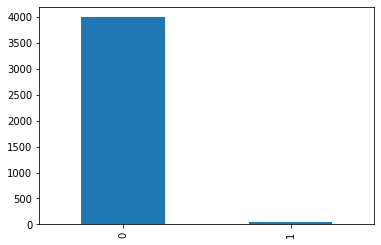

In [1556]:
#Confirm our target variable is imbalanced
y.value_counts().plot(kind='bar')

In [1557]:
#Ordinally encode categorical columns
enc = OrdinalEncoder()
X = enc.fit_transform(X)

In [1558]:
#Run Iterative Imputer to replace all missing values
imp_mean = IterativeImputer(random_state=42)
X[:] = imp_mean.fit_transform(X)

In [1559]:
#Split data into training, validation, and test sets
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.6
ratio_val = 0.2
ratio_test = 0.2

# Produce test split.
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produce train and val splits.
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=ratio_val_adjusted)

In [1560]:
#Oversample our minority classes using SMOTE (only on the training data)
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

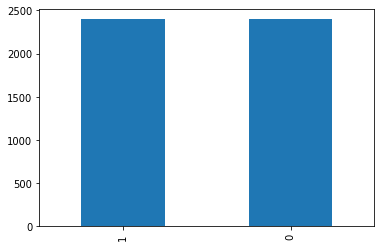

In [1561]:
#Check that our target variable is now balanced
y_train_res.value_counts().plot(kind='bar')

In [1562]:
#Run function to transform skewed columns
skew_autotransform(X_train_res, exclude = ['S_METALLICITY'], threshold = 24, exp=True)
    

,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_FLUX_MIN,P_TEMP_EQUIL_MIN,S_TIDAL_LOCK,P_HABZONE_OPT,P_ESI,P_RADIUS_EST
0,40.530000,0.190000,0.680000,-0.390820,-1.075191,194.718650,0.405684,1.0,0.413785,9.323373
1,142.400000,-0.250000,0.710000,5.098404,5.098404,911.374970,0.411564,0.0,0.298234,1.210680
2,1202.000000,0.030000,1.150000,4.843378,4.843378,855.082380,0.448843,0.0,0.250917,2.286840
3,1284.000000,0.010000,0.970000,2.545963,2.545963,481.470090,0.451045,0.0,0.315480,2.667980
4,338.050000,-0.008636,0.893041,5.241036,5.241036,944.459120,0.438167,0.0,0.295771,1.255520
...,...,...,...,...,...,...,...,...,...,...
4789,178.667689,-0.180454,0.758464,0.197741,0.197741,267.340369,0.424426,1.0,0.726709,2.185185
4790,513.355551,-0.054128,0.752640,0.175874,0.175874,265.665183,0.396066,1.0,0.710431,2.332691
4791,9.059637,-0.461675,0.491928,-0.048828,-0.293001,236.521543,0.330409,1.0,0.802683,1.827407
4792,686.774330,-0.005270,0.919722,0.083614,-0.006829,252.647049,0.419071,1.0,0.701838,2.407118


In [1563]:
#Take a look at our training data pandas profile to check for any outstanding issues
ProfileReport(X_train_res, minimal=True)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [1564]:
#Get baseline accuracy for our training set
baseline_acc = y_train_res.value_counts(normalize=True).max()
print(baseline_acc)

0.5


In [1565]:
#Run logistic regression model on our training data
model_logr =  make_pipeline(StandardScaler(), 
                            LogisticRegression(random_state=42)
                           )

model_logr.fit(X_train_res, y_train_res);

In [1566]:
#Get accuracy for logistic regression validation and test sets
val_acc = model_logr.score(X_val, y_val)
test_acc = model_logr.score(X_test, y_test)

print('Validation Accuracy:', val_acc)
print('Test Accuracy:', test_acc)

Validation Accuracy: 0.991358024691358
Test Accuracy: 0.9987654320987654


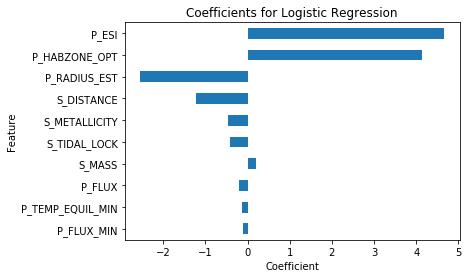

In [1567]:
#Create horizontal bar chart showing regression coefficients
coefficients = model_logr.named_steps['logisticregression'].coef_.flatten()
features = X_train_res.columns
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Logistic Regression');

In [1568]:
#Run random forest classifier on our training data
model_rf = RandomForestClassifier(n_estimators=50,
                                  n_jobs=-1,
                                  random_state=42)

model_rf.fit(X_train_res, y_train_res);

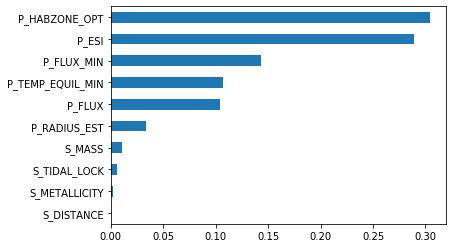

In [1569]:
#Plot feature importances for the random forest classifier model
importances = model_rf.feature_importances_
features = X_train_res.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

In [1570]:
#Get random forest model validation set accuracy score
val_acc = accuracy_score(y_val, model_rf.predict(X_val))
print(val_acc)

0.9962962962962963


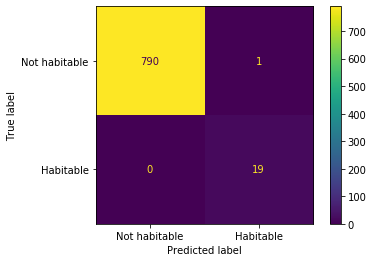

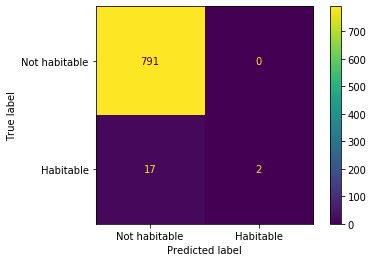

In [1571]:
#Create confusion matrix for logistic regression
plot_confusion_matrix(model_logr,
                      X_test,
                      y_test,
                      values_format='.0f',
                      display_labels=['Not habitable', 'Habitable']);

#Create confusion matrix for random forest
plot_confusion_matrix(model_rf,
                      X_test,
                      y_test,
                      values_format='.0f',
                      display_labels=['Not habitable', 'Habitable']);

In [1572]:
#Create classification report for the logistic regression and random forest model using the test data
print('Logistic Regression :')
print(classification_report(y_test, model_logr.predict(X_test)))
print('Random Forest :')
print(classification_report(y_test, model_rf.predict(X_test)))

Logistic Regression :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       0.95      1.00      0.97        19

    accuracy                           1.00       810
   macro avg       0.97      1.00      0.99       810
weighted avg       1.00      1.00      1.00       810

Random Forest :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       791
           1       1.00      0.11      0.19        19

    accuracy                           0.98       810
   macro avg       0.99      0.55      0.59       810
weighted avg       0.98      0.98      0.97       810



In [1573]:
#Get permutation importances
perm_imp = permutation_importance(model_logr,
                                 X_val,
                                 y_val,
                                 n_repeats=5,
                                 n_jobs=-1,
                                 random_state=42)

In [1574]:
#Create dataframe containing permutation importances
perm_data = {'imp_mean' : perm_imp['importances_mean'],
            'imp_std' : perm_imp['importances_std']}

perm_df = pd.DataFrame(perm_data, index=X_val.columns).sort_values('imp_mean')

In [1575]:
#View permutation importances dataframe
perm_df

,imp_mean,imp_std
P_FLUX_MIN,-0.003704,0.001562
P_FLUX,-0.003704,0.000781
P_ESI,-0.002963,0.000988
P_HABZONE_OPT,-0.002716,0.001975
S_DISTANCE,-0.001481,0.000494
S_TIDAL_LOCK,-0.000741,0.000605
S_METALLICITY,0.000000,0.000000
S_MASS,0.000000,0.000000
P_TEMP_EQUIL_MIN,0.000000,0.000000
P_RADIUS_EST,0.001975,0.002153


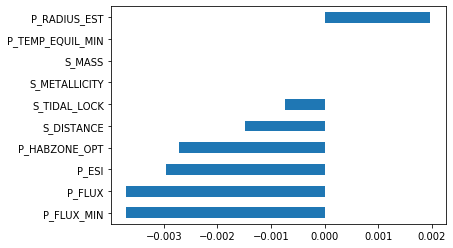

In [1576]:
#Plot permutation importances
perm_df['imp_mean'].tail(10).plot(kind='barh');

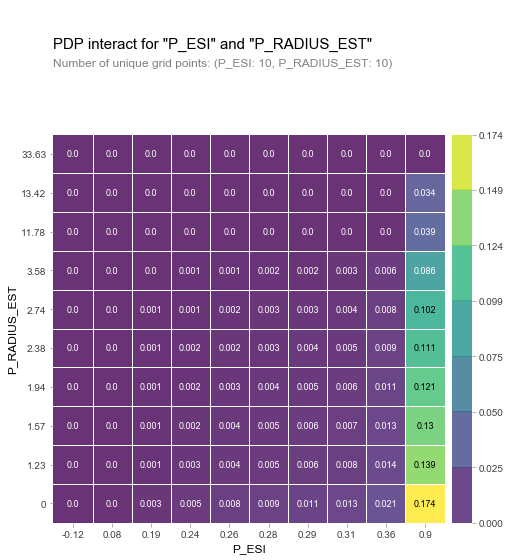

In [1577]:
#Create partial dependence plot
features = ['P_ESI', 'P_RADIUS_EST']

interact = pdp_interact(
model_logr,
dataset=X_val,
model_features= X_val.columns,
features=features)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);